# Create multi-task adjustment for cross-entropy
> A weighter for multi-task learning with different softmax+cross-entropy

## Tools and imports

In [ ]:
# default_exp multitask_ce

In [1]:
# export
import torch
from torch import nn
import pandas as pd
import numpy as np
from typing import Callable

In [120]:
from matplotlib import pyplot as plt

## Enters softmax

In [102]:
softmax = nn.Softmax(-1)
crit = nn.CrossEntropyLoss()

## Experience the problem

In [104]:
def test_loss(model,iters:300,get_xy):
    losses=[]
    with torch.no_grad():
        for i in range(iters):
            x,y_true = get_xy(model.nb_output)
            y_vec = model(x)
            loss = model.crit(y_vec,y_true)
            losses.append(loss)
    return torch.stack(losses).mean()

In [245]:
def create_softmax_pipeline(
        nb_layers:int,
        nb_output:int,
        hs:int=500,
        crit:nn.Module=nn.CrossEntropyLoss(),
    )->nn.Module:
    modules = (nb_layers-1)*[nn.Linear(hs,hs),nn.Dropout(.3)]
    modules+=[nn.Linear(hs,nb_output),]
    model = nn.Sequential(*modules)
    model.hs = hs
    model.nb_output = nb_output
    model.__class__.crit = crit
    model.__class__.test_loss = test_loss
    return model

In [246]:
def random_input(nb_output):
    return torch.rand(2,500),torch.randint(low=0,high=nb_output,size = (2,))

def inbalanced_input(
        bias:float
    ) -> Callable:
    def inbalanced_input_(nb_output:int):
        return torch.rand(2,500),torch.randint(
            low=0,
            high=max(1,int(nb_output*bias)),
            size = (2,)
        )
    return inbalanced_input_

* For models with different branches of output, some output 2 category, some output more, like 200,500
* Their loss will end up in different scale
* That makes mixing them up fairly hard and unfair to lesser category tasks

In [247]:
import random

In [266]:
result = []

for i in tqdm(range(50)):
    c = random.randint(2,3000)
    b = 1-random.random()
    loss = create_softmax_pipeline(1,c).test_loss(300,inbalanced_input(b))
    result.append(dict(classes=c,loss=loss.item(),inbl_bias=b))

In [267]:
df = pd.DataFrame(result)

In [268]:
df

,classes,loss,inbl_bias
0,2244,7.784015,0.719190
1,2447,7.849158,0.002960
2,706,6.625416,0.297956
3,272,5.739001,0.154829
4,2860,7.994882,0.179631
5,2376,7.823036,0.554090
6,474,6.230643,0.497769
7,1476,7.317650,0.790722
8,729,6.652312,0.671657
9,1183,7.161001,0.422553


### The pattern

There are $n$ tasks $T$ with a set of numbers of classes $C$ where $c_{i}$ is the number of the classes of task $T_{i}$

The number of classes $c_{i}$ has certain correlation of the average loss $L_{i}$

Where $log_{10}(c_{i})$ has a clear linear relationship with $L$

$L_{i} = a.log_{10}(c_{i})$, where a is a fixed constant

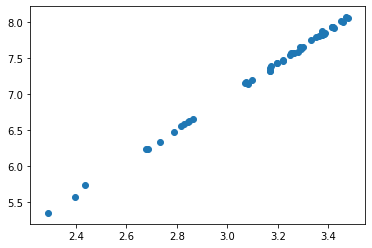

In [269]:
plt.scatter(np.log10(df.classes),df.loss,)

### The solution

Assume we have certain function, will produce a weight that will bring each cross entropy loss to the same constant scale ${a}$.

$L_{i}.f(c_{i})=a$

$f(c_{i})a.log_{10}(c_{i})=a$

Here we can get how to calculate $f(c_{i})$

$f(c_{i})=\frac{1}{log_{10}(c_{i})}$

In [270]:
def adjust(nb_class):
    return 1/np.log10(nb_class)

In [271]:
df["lambda_weighted"] = df.apply(
    lambda row:row['loss']*adjust(row['classes']),
    axis=1)

For now it's a about the same scale of loss

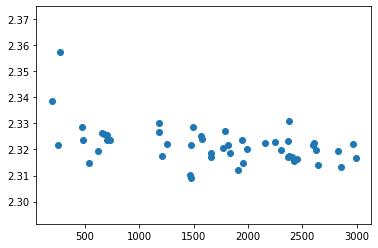

In [272]:
plt.scatter(df.classes,df.lambda_weighted)

## Adjusted CrossEntropy

In [288]:
# export
class MultiTaskCELoss(nn.Module):
    """
    A cross entropy loss function which will cancel out
        the effect of different class numbers
    """
    def __init__(self,):
        super().__init__()
        self.celoss = nn.CrossEntropyLoss()
        
    def forward(
        self,
        y_pred: torch.FloatTensor,
        y_true: torch.LongTensor,
    )-> torch.FloatTensor:
        """
        Input:
            - y_pred: torch.FloatTensor, Prediction tensor
            - y_true: torch.LongTensor, Label indices
        Return:
            - loss: torch.FloatTensor, scala adjusted
        """
        nb_classes = y_pred.size(-1)
        lambda_ = 1/np.log10(nb_classes)
        loss = self.celoss(y_pred,y_true)
        return loss*lambda_

Let's make this adjustment into the loss function, an upgraded version of CrossEntropy

In [289]:
result = []

for i in tqdm(range(50)):
    c = random.randint(2,3000)
    b = 1-random.random()
    # here we change the loss function to MultiTaskCELoss
    loss = create_softmax_pipeline(1,c,crit=MultiTaskCELoss())\
        .test_loss(300,inbalanced_input(b))
    result.append(dict(classes=c,loss=loss.item(),inbl_bias=b))

In [283]:
df_adjusted = pd.DataFrame(result)

In [284]:
df_adjusted

,classes,loss,inbl_bias
0,533,2.319248,0.208584
1,2264,2.326346,0.022896
2,254,2.320735,0.922445
3,1027,2.328291,0.643444
4,2428,2.326136,0.883795
5,772,2.317071,0.062716
6,2166,2.315754,0.364122
7,812,2.321972,0.852977
8,2632,2.321708,0.639467
9,2576,2.313269,0.968200


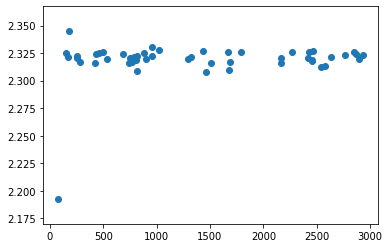

In [287]:
plt.scatter(
    df_adjusted.classes,
    df_adjusted.loss,
)